In [2]:
import numpy as np
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import seaborn as sb

ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
def load_data():
    data = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/data.txt",  encoding='utf-8',sep='\t',lineterminator='\n',names=['USER','MOVIE','RATING'],header=None)
    train = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/train.txt",  encoding='utf-8',sep='\t',lineterminator='\r',names=['USER','MOVIE','RATING'],header=None)
    test = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/test.txt",  encoding='utf-8',sep='\t',lineterminator='\r',names=['USER','MOVIE','RATING'],header=None)
    movies = pd.read_csv("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/movies.txt", encoding='latin-1',sep='\t',header=None)
    movies.columns=['MOVIE_ID','TITLE','UNKNOWN','ACTION','ADVENTURE','ANIMATION','CHILDREN','COMEDY','CRIME','DOCUMENTARY','DRAMA','FANTASY','FILM-NOIR','HORROR','MUSICAL','MYSTERY','ROMANCE','SCI-FI','THRILLER','WAR','WESTERN']
    return data,movies,train,test

In [8]:
data,movies,train,test = load_data()

In [11]:
print(test)

      USER  MOVIE  RATING
0      707    766       3
1      943    188       4
2      772    313       5
3      828     26       3
4      854    514       4
...    ...    ...     ...
9995    13    858       1
9996     7     79       4
9997   588   1058       2
9998   916    727       4
9999   833    118       2

[10000 rows x 3 columns]


In [51]:
def grad_U(Ui, Yij, Vj, ai,bj,reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    gradU = reg*Ui-(Yij-np.dot(Ui,Vj)-ai-bj)*Vj;
    return gradU*eta  

def grad_V(Vj, Yij, Ui, ai,bj,reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    gradV = reg*Vj-(Yij-np.dot(Ui,Vj)-ai-bj)*Ui;
    return gradV*eta  

def grad_a(Vj,Yij,Ui,ai,bj,reg,eta):
    grada = -(Yij-np.dot(Ui,Vj)-ai-bj)
    return grada*eta

def grad_b(Vj,Yij,Ui,ai,bj,reg,eta):
    gradb = -(Yij-np.dot(Ui,Vj)-ai-bj)
    return gradb*eta

def get_err(U, V, Y, a,b,reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    sum =0
    for i in range(0,Y.shape[0]):
        sum = sum+ (Y[i,2]-np.dot(U[Y[i,0]-1,:],V[Y[i,1]-1,:])-a[Y[i,0]-1]-b[Y[i,1]-1])**2
    loss = reg/2*(np.linalg.norm(U,ord='fro')**2+np.linalg.norm(V,ord='fro')**2)+sum/2
    return loss/(Y.shape[0])


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    err = np.inf
    cur_epoch = 0

    #generate random U,V
    U = np.random.rand(M,K)
    U = U-0.5*np.ones_like(U)
    V = np.random.rand(N,K)
    V = V-0.5*np.ones_like(V)
    a = np.random.rand(M)
    a = a-0.5*np.ones_like(a)
    b = np.random.rand(N)
    b = b-0.5*np.ones_like(b)
    print(b.shape)

    #Perform SGD
    prev_err = 0
    while cur_epoch < max_epochs and np.abs(prev_err-err)>eps:
        prev_err = err

        #shuffle indices
        ind_shuff = np.arange(Y.shape[0])
        np.random.shuffle(ind_shuff)
        for k in range(0,ind_shuff.shape[0]):
            i = Y[ind_shuff[k],0]-1
            j = Y[ind_shuff[k],1]-1
            Yij = Y[ind_shuff[k],2]
            U[i,:] = U[i,:]-grad_U(U[i,:],Yij,V[j,:],a[i],b[j],reg,eta)
            V[j,:] = V[j,:]-grad_V(V[j,:],Yij,U[i,:],a[i],b[j],reg,eta)
            a[i] = a[i]-grad_a(V[j,:],Yij,U[i,:],a[i],b[j],reg,eta)
            b[j] = b[j]-grad_b(V[j,:],Yij,U[i,:],a[i],b[j],reg,eta)

        #Calculate error
        err = get_err(U,V,Y,a,b,reg)
        cur_epoch = cur_epoch+1
        print(cur_epoch)
        print(err)
    
    err = get_err(U,V,Y,a,b)
    
    return U,V,a,b,err


Factorizing with  943  users,  1682  movies.
(1682,)
1
0.4912844249131481
2
0.41118152085248083
3
0.3715993226350924
4
0.34517674428884965
5
0.3241241190241951
6
0.3089850638243667
7
0.298247310179811
8
0.2890715321764517
9
0.2822948732921908
10
0.2764250032111788
11
0.2718046078783686
12
0.2683359045632111
13
0.2642067611254164
14
0.2617558035885847
15
0.25981646998004865
16
0.25680095253741886
17
0.2553628198445774
18
0.25296106853588957
19
0.2511054858405595
20
0.2496380051017265
21
0.2491980115134294
22
0.2481424425969785
23
0.24655610215690751
24
0.2461246960286228
25
0.24545061139784682
26
0.24445092116748612
27
0.24308937271069073
28
0.2429180295770122
29
0.24211203105271564
30
0.24170068573755019
31
0.2405188350447302
32
0.24012943858095886
33
0.23924726857748302
34
0.2387134963694299
35
0.23912962824029846
36
0.23838065558621963
37
0.23767771584490713
38
0.2376160078280226
(1682,)
1
0.4700279895689585
2
0.3698197990690939
3
0.320472162135743
4
0.28723282276290324
5
0.263476081

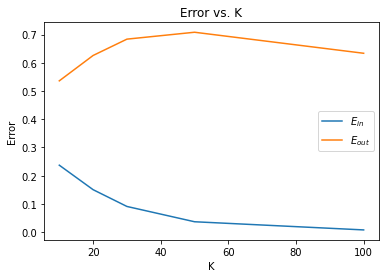

In [76]:
Y_train = train.to_numpy()
Y_test = test.to_numpy()

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
Ks = [10,20,30,50,100]

reg = 0.01
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U_best = []; V_best = []; a_best = []; b_best = [];
cur_err = np.inf
for K in Ks:
    U,V,a,b, err = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(err)
    test_err = get_err(U, V, Y_test,a,b)
    E_out.append(test_err)
    if test_err<cur_err:
        U_best = U; V_best = V; a_best = a; b_best = b;
        cur_err = test_err

plt.plot(Ks, E_in, label='$E_{in}$')
plt.plot(Ks, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2d.png')

In [67]:
#Compute SVD;
A,S,B = np.linalg.svd(V_best.T)
print(A.shape)
print(V_best.shape)
Vtilde = V_best@A[:,0:2]
print(Vtilde.shape)

(100, 100)
(1682, 100)
(1682, 2)


[ 551  288   84  288  438  563  208  288  573  438  861 1520  413  437
  670  816  665 1199  674  573]
[ 580  419  517 1308 1178 1659 1534  377  422   42  236 1234 1567  732
  477 1611 1435 1494 1385  482]
[ 781 1357  921  631  213 1024 1258  306  732  732 1160  694  490  877
 1679 1485  594  835 1258  870]
[1244  916  313  797  374 1393 1181 1433 1358  879 1180 1250  313  210
  172 1244  566 1548   54  831]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without 

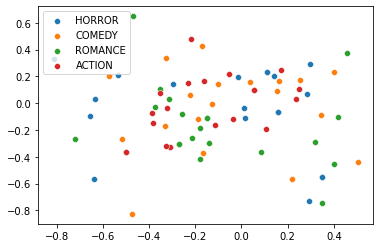

In [75]:
#Get representative datapoints
clusters = ['HORROR','COMEDY','ROMANCE','ACTION']
n_cluster = 20
cluster_data = np.zeros((n_cluster,2,len(clusters)))
for c in range(0,len(clusters)):
    genre_data = movies[lambda x: x[clusters[c]]==1]
    cluster_inds = np.random.choice(genre_data['MOVIE_ID'],n_cluster)
    cluster_data[:,:,c] = Vtilde[cluster_inds,:]

plt.figure()
for c in range(0,len(clusters)):
    sb.scatterplot(x=cluster_data[:,0,c],y=cluster_data[:,1,c])

plt.legend(clusters)
        